# WOfS the hell

### List of wetland edits

push to github every time you change one of these!!!!
- wofs bit flags - include low angle wofs
- check for 90% coverage of shape, not just load
- if no data, redo load with no 90% thing, then monthly aggregate before checking for coverage
-  tighten graph and increase text size


- wofs - plot to see what the actual values are in between 
- wofs - fill gaps with ndwi
- wofs - plot against surface reflectance

- use bens awesome stats code to gap fill?

- rolling average for inference?
        

### import modules


In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from digitalearthau.utils import wofs_fuser

sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='tci and wofs')

%load_ext autoreload

%autoreload 2

### Set up polygon

In [2]:
#change the path here if you want a different polygon
#poly_path = '/g/data/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/reeves_lake_for_demo.shp'
poly_path = '/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/ExplodedRAMSAR.shp'

In [3]:
#open the polygon and manually select your favourite polygon the lazy way
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        #first_geometry = next(iter(shapes))['geometry']
        #geom = geometry.Geometry(first_geometry, crs=crs)
        for feature in shapes:
            #print(feature['properties']['WETLAND_NA'])
            if feature['properties']['WETLAND_NA']=='Lake Charm':
                lake_charm =feature
                lake_charm_geometry = lake_charm['geometry']
                geom = geometry.Geometry(lake_charm_geometry, crs=crs)

### Set up query

In [4]:
query = {'geopolygon': geom,
         #'time': ('2016-01-01', '2018-06-30')
         #'time': ('2007-01-01', '2007-06-30')
         'time': ('2018-01-01', '2019-01-01')
         }

### Load cloudmasked data

### mask the data with our original polygon to remove extra data 

In [5]:
landsat_masked_prop = 0.90
ls578 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',masked_prop=landsat_masked_prop)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 13 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### let's have a look at our data looks in false color

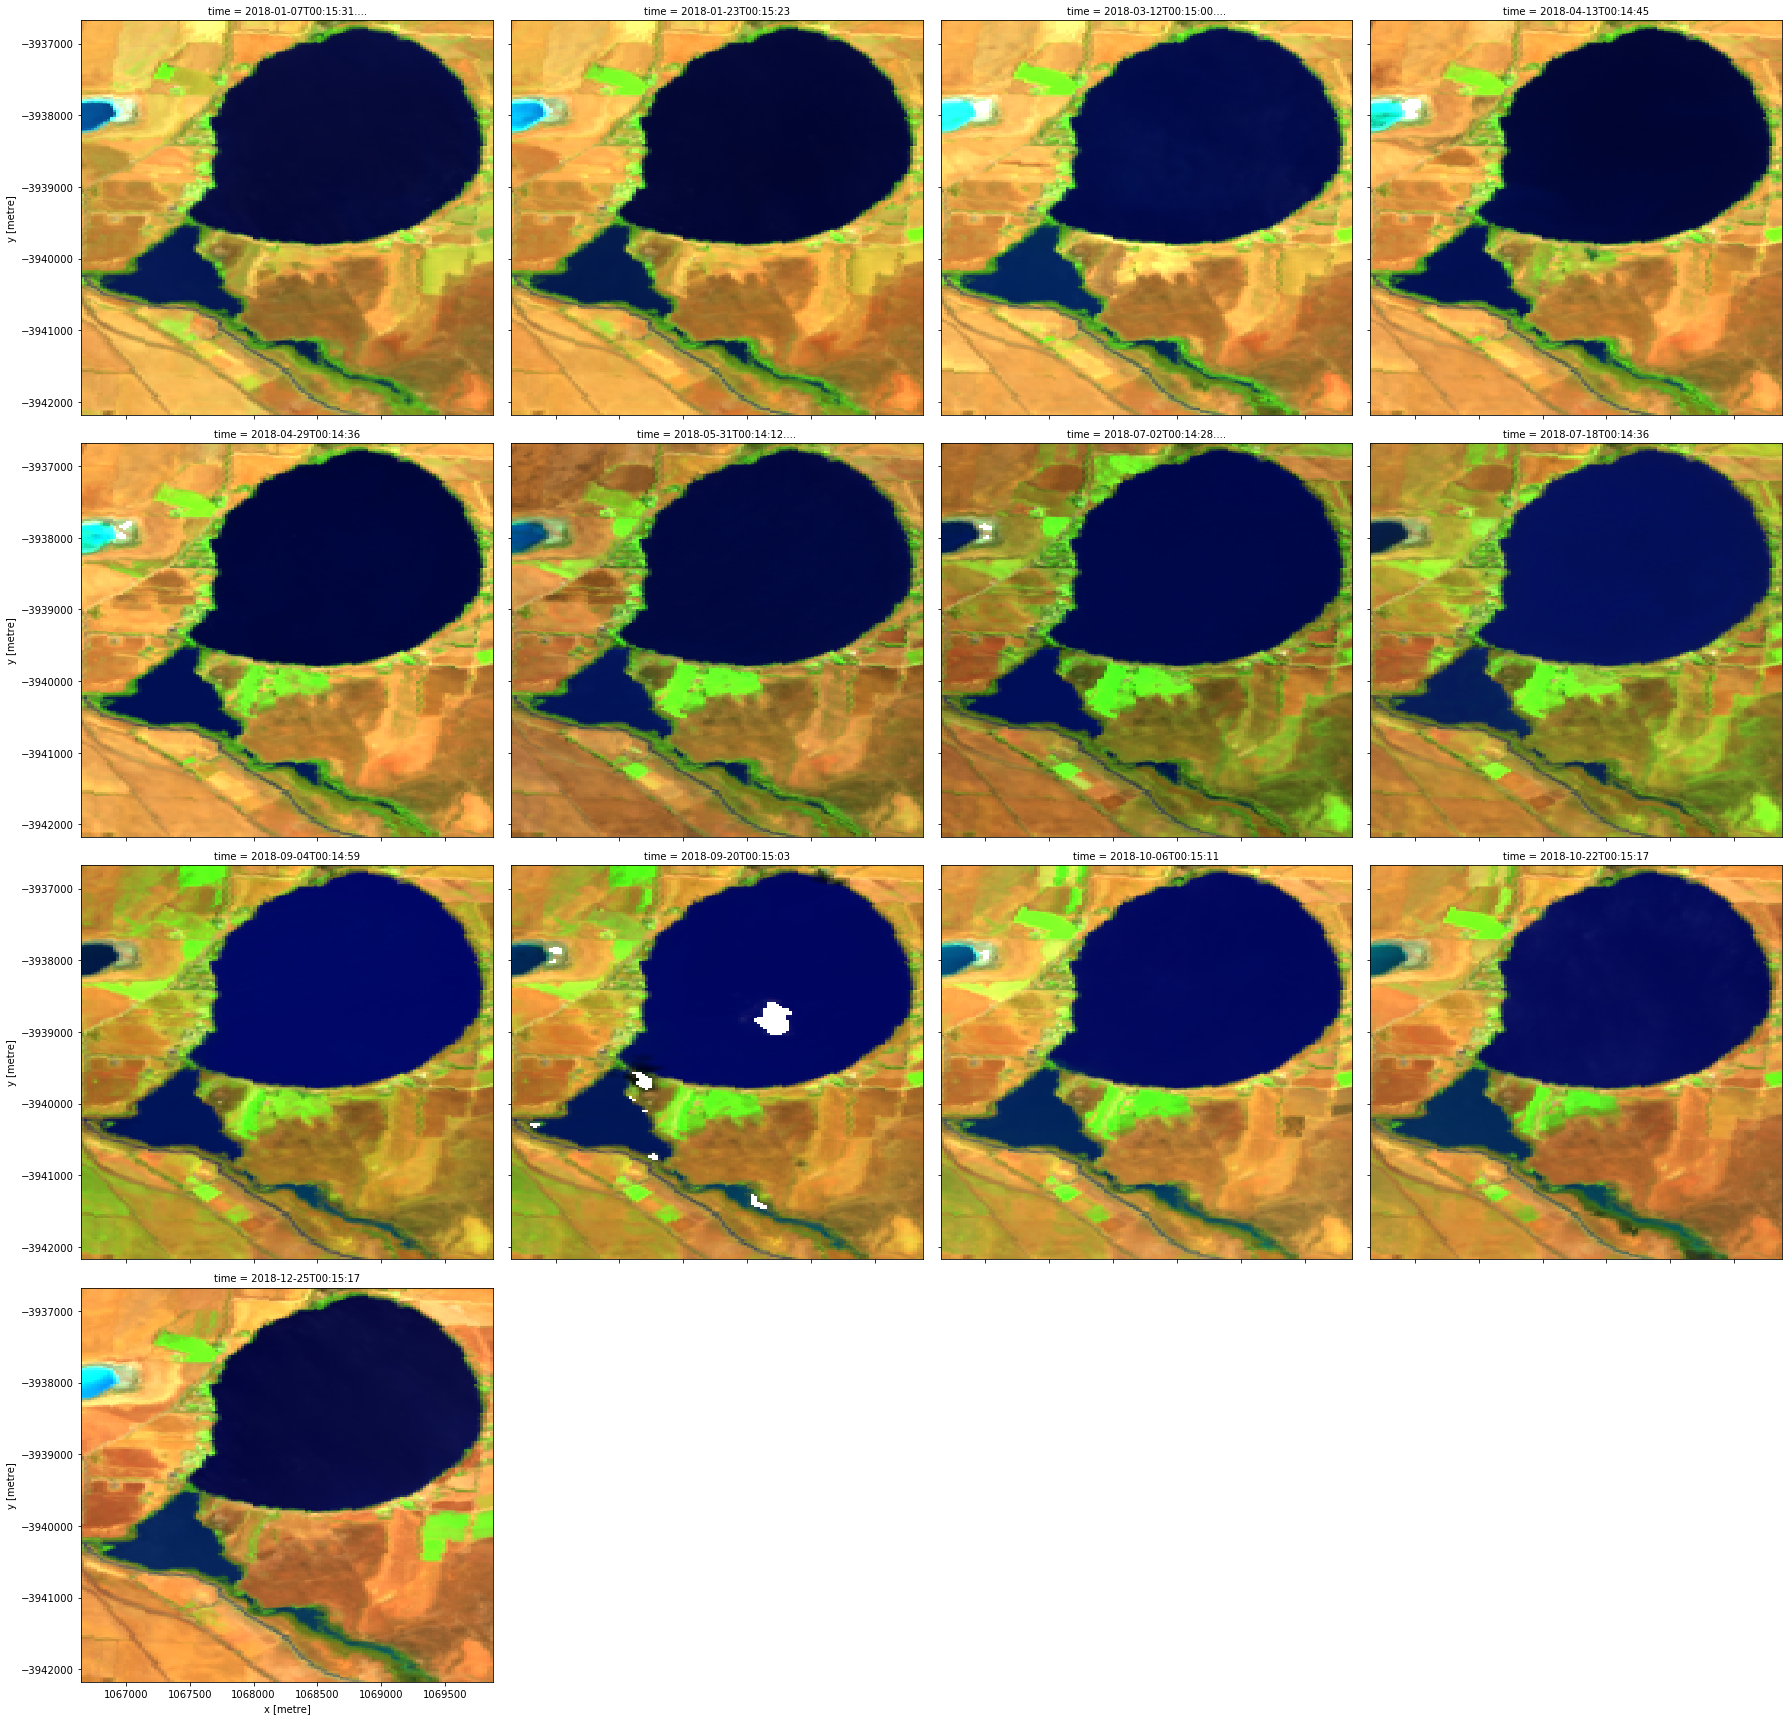

In [6]:
DEAPlotting.rgb(ls578, bands=['swir1','nir','green'], col='time')

In [7]:
data = ls578

mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                           out_shape=data.geobox.shape, 
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=False)

In [8]:
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))
ls578_ds = data.where(mask_xr==False)

In [9]:
#transform the nbart into tci
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

In [10]:
#select only finite values (over threshold values)
tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

In [11]:
# #reapply the polygon mask
tcw = tcw.where(mask_xr==False)

# trying to fix wofs flagging

In [12]:
### try using dc load instead of 'like'

In [16]:
#load wofs
#wofls = dc.load(product = 'wofs_albers', like=ls578_ds, fuse_func=wofs_fuser)
wofls = dc.load(product = 'wofs_albers',fuse_func=wofs_fuser, **query)

#first, match tcw and wofs

In [18]:
wofls = wofls.where(wofls.time ==tci.time)

In [26]:
#reapply the polygon mask
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))
wofls = wofls.where(mask_xr==False)

## plot wofs data for all bit flags

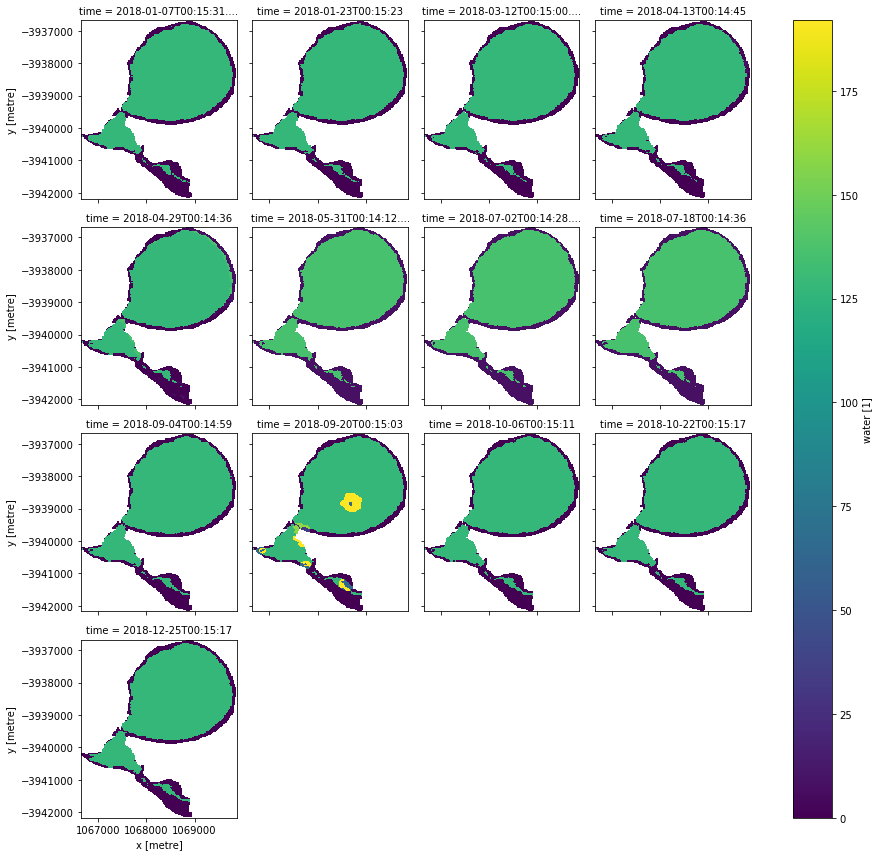

In [27]:
wofls.water.plot(col='time', col_wrap=4)

## plot only wet wofs obs

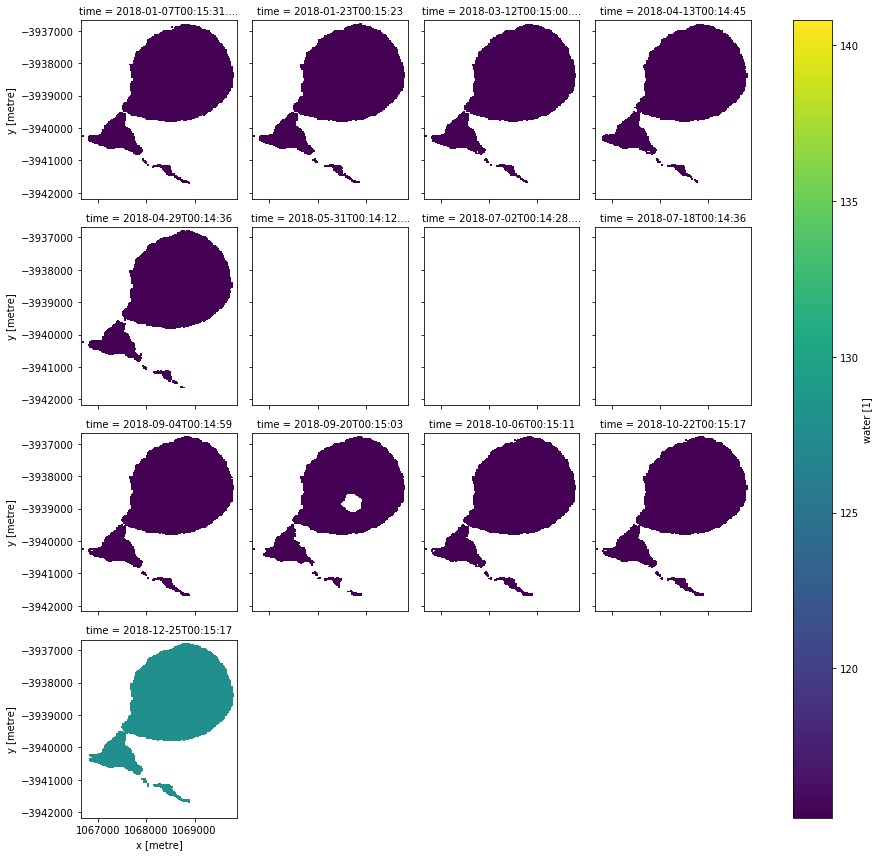

In [28]:
wet_wofs = wofls.where(wofls.water==128)
wet_wofs.water.plot(col='time', col_wrap=4)

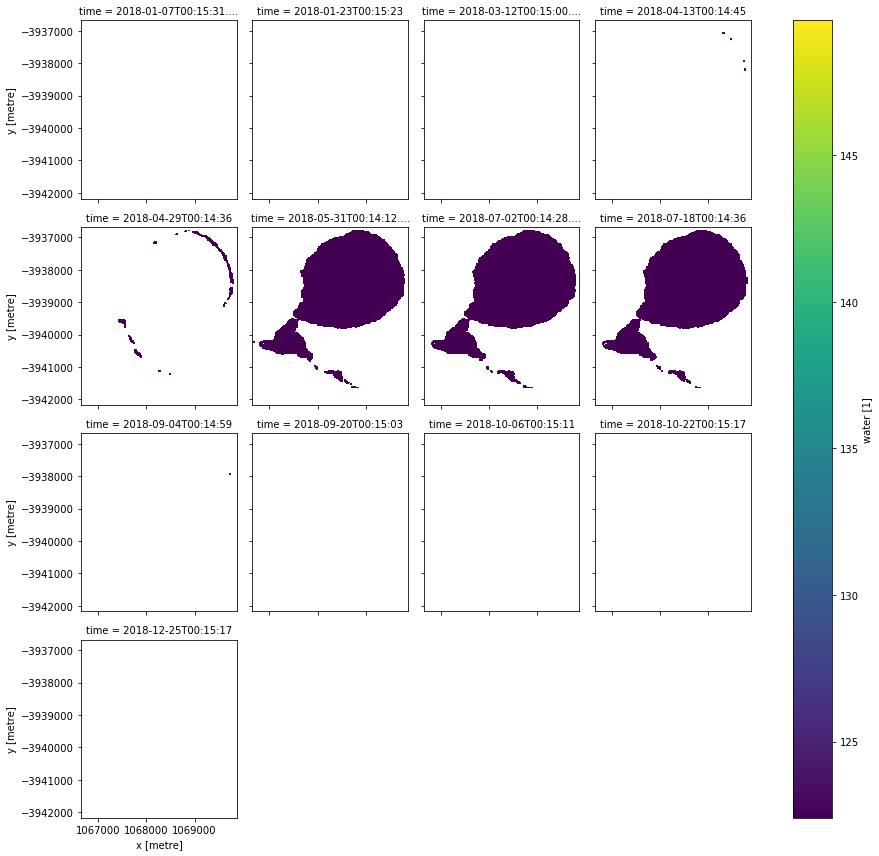

In [29]:
shadow_wofs = wofls.where(wofls.water== 136)
shadow_wofs.water.plot(col='time', col_wrap=4)

In [ ]:
### bit flagging stuff

#pd_wofs = masking.describe_variable_flags(wofls, with_pandas=True)

#pd_wofs['test_binary'] = pd_wofs['bits']
# #stuffing around just to get bit
# lmbda = lambda x:2**x

# newlist = []
# #replace values in list with binary values
# for i in pd_wofs['test_binary'][2]:
#     i = lmbda(i)
#     newlist.append(i)
# print(newlist)
# newlist2 =[]
# for i in pd_wofs['test_binary'][-1]:
#     i= lmbda(i)
#     newlist2.append(i)
# print(newlist2)

# pd_wofs['test_binary'][2]=newlist
# pd_wofs['test_binary'][-1]=newlist2

In [ ]:
wetwofl

In [ ]:
wetwofl.water[-5:-1].plot(col='time', col_wrap=5)

In [ ]:
### bitwise or \ for both masks to join together

In [ ]:
## checking to make sure the masking is only taking what we want

In [ ]:
# wofls

In [ ]:
# #only get wet obs
# wetwofl = masking.make_mask(wofls, terrain_or_low_angle=True)

In [ ]:
# wetwofl

In [ ]:
# wofls.water.isel(time=-1).max()

### load in fractional cover data

In [ ]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

### mask FC with polygon

In [ ]:
fc_ds

In [ ]:
fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

In [ ]:
fc_ds_noTCW=fc_ds.where(tcw==False)

In [ ]:
#set scene to plot
scene =2

In [ ]:
# #set up our images on a grid using gridspec
# plt.clf()
# plt.figure(figsize=(12,8))
# gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

# ax1=plt.subplot(gs[0,0])
# fc_ds_noTCW.PV.isel(time=scene).plot(cmap='gist_earth_r')
# ax1.set_title('PV')

# ax2=plt.subplot(gs[1,0])
# fc_ds_noTCW.BS.isel(time=scene).plot(cmap='Oranges')
# ax2.set_title('BS')

# ax3=plt.subplot(gs[0,1])
# fc_ds_noTCW.NPV.isel(time=scene).plot(cmap='copper')
# ax3.set_title('NPV')

# ax4=plt.subplot(gs[1,1])
# fc_ds_noTCW.UE.isel(time=scene).plot(cmap='magma')
# ax4.set_title('UE')

# plt.tight_layout()
# plt.show()

### Calculate number of pixels in area of interest

In [ ]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [ ]:
mask_xr==0
mask_xr.count(dim=['x','y'])

In [ ]:
#count number of wofs pixels
wofs_pixels = wetwofl.water.sum(dim=['x','y'])

#count percentage of area of wofs
wofs_area_percent = (wofs_pixels/pixels)*100

#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

#calculate percentage area wet
tcw_area_percent = (tcw_pixel_count/pixels)*100

#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

### Calculate the dominant fraction for each pixel in Fractional Cover

In [ ]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

In [ ]:
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [ ]:
FC_count = FC_dominant.sum(dim=['x','y'])

In [ ]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon

Bare_soil_percent=(FC_count.BS/pixels)*100

Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

In [ ]:
wofs_area_percent=wofs_area_percent.where(wofs_area_percent.time==Bare_soil_percent.time)
wofs_area_percent

In [ ]:
tcw_less_wofs

In [ ]:
query['time'][0]

In [ ]:
#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"],
      sns.xkcd_rgb["grey"]]

#make a stacked area plot
plt.clf()
plt.figure(figsize = (12,6))
plt.stackplot(wofs_area_percent.time.values, 
              wofs_area_percent, 
              tcw_less_wofs, 
              Photosynthetic_veg_percent, 
              NonPhotosynthetic_veg_percent,
              Bare_soil_percent,
              NoData,
              labels=['open water',
                      'wet',
                      'green veg',
                      'dead veg',
                      'bare soil',
                      'NoData'
                     ], colors=pal, alpha = 0.6)

plt.title('Percentage of area WOfS, Wetness, Fractional Cover')

#set axis limits to the min and max
plt.axis(xmin = query['time'][0], xmax = query['time'][1], ymin = 0, ymax = 100)

#set date ticks every year
years = mdates.YearLocator(2)
yearsFmt = mdates.DateFormatter('%Y')
ax = plt.gca()
#ax.xaxis.set_major_locator(years)
#ax.xaxis.set_major_formatter(yearsFmt)

#add a legend and a tight plot box
plt.legend(loc='upper right')
plt.tight_layout()

#save the figure
#plt.savefig('/g/data/r78/rjd547/Ramsar_Wetlands/Old_Dromana_Gwydir_2013_2019.png')#, transparent=True)
plt.show()